NOTE : Lors de l'execution des cellules, il peut y avoir un conflit entre plots plt et animations du a un bug de jupyter. Si lors de l'exécution d'une cellule, le plot ou l'animation n'apparait pas, ré-exécuter la cellule et ce dernier devrait apparaitre. Si après quelques exécutions ce n'est toujours pas le cas, redémarrer le kernel 

Executer les cellules deux fois fait aussi partir le message rouge d'erreur, mais celui ci n'influence pas les résultats obtenus.

In [10]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import collections

# Projet informatique controle de pendule  - BLATTNER Romain

## 1) Pendule fixe

Nous désirons controler un pendule simple de sa position d'équilibre stable a sa position d'équilibre instable, et de l'y maintenir.

L'équation du pendule simple est : 

$$
ml\ddot\theta +\lambda\dot\theta +mgsin(\theta) = 0
\tag{1}
\label{1}
$$

ou m est la masse de la masselote, l la longue du pendule, theta l'angle formé entre le pendule et la verticale, et lambda un facteur de frottement (air, laison imparfaite)

Afin de controler ce system dynamique, nous devons avoir un moyen d'action sur celui ci. Dans un premier temps nous allons supposer que nous pouvons appliquer un couple directement sur le pendule. 

Celle ci est représentée par une commande u sur l'angle theta, qu'on pourra notre comme moment en appliquant le TMC :

$$
ml\ddot\theta +\lambda\dot\theta +mgsin(\theta) = u(t)
\tag{2}
\label{2}
$$


Nous définissons le vecteur du système : $$X= \left(\begin{array}{cc} \theta \\ \dot\theta \end{array}\right) \;\;\;\;\;\;\; \dot X= \left(\begin{array}{cc} \dot\theta \\ \ddot\theta \end{array}\right)$$ 

Afin de réécrire l'équation dynamique sous la forme : $$\dot X = F(X,U)$$

Ceci nous sera utile lors de la stabilisation autour d'une position d'équilibre, ou nous pourrons linéariser ce système à l'aide d'un DL

In [3]:
##Definition des variables du problème

m = 0.5; # masse du pendule
M = 1    # masse chariot
L = 0.3; # longueur du fil
lambdas = 0.1; # coefficient de frottement
g = 9.81; # gravité

### A) Trajectoire de référence

On cherche a définir une trajectoire de référence qui peut ammener notre pendule de sa position initiale stable de $\theta = 0$ à $\theta = \pi$. 
On a comme conditions supplémentaires que sa vitesse $\dot\theta$ soit nulle au départ et a l'arrivée. 

Avec un tel jeu de contraintes, nous pouvons en premiere approche, utiliser un polynome pour satisfaire ces conditions. 

$$
\theta(t) = a_0 + a_1t + a_2t^2 + a_3t^3
\tag{1}
\label{1} $$


Nous en déduisons que:
$$\theta(0) = a_0 = 0 $$
$$\dot\theta(0) = a_1 = 0$$
$$\theta = a_2t_f^2 + a_3t_f^3 = \pi$$
$$\dot\theta= 2a_2t_f + 3a_3t_f^2 = 0$$

Grace à l'équation (1) , nous pouvons facilement en déduire la loi de commande de référence ur.


In [4]:
X0 = np.zeros((1,2))
Xf = np.array([np.pi-10**-5,0])
tf = 3
time = np.linspace(0,4*tf,500,1)

A = np.array([[1,0,0,0],[0,1,0,0],[1,tf,tf**2,tf**3],[0,1,2*tf,3*tf**2]])

B = np.concatenate((X0,Xf),axis=None)

coeff_r = np.linalg.solve(A,B)  #on déduit les coefficients de notre polynome de trajectoire en résolvant système.
print(coeff_r)
    

[ 0.          0.          1.04719422 -0.23270983]


D'ici, nous définissons les fonctions $\theta_{ref}(t)$ $\dot\theta_{ref}(t)$ $\ddot\theta_{ref}(t)$ et $u_{ref}(t)$

In [5]:
def thetar(t):
    if t<= tf:
        return coeff_r[0] + coeff_r[1]*t + coeff_r[2]*t**2 + coeff_r[3]*t**3
    elif t>tf:
        return Xf[0]

def dthetar(t):
    if t<= tf:
        return coeff_r[1] + 2*coeff_r[2]*t + 3*coeff_r[3]*t**2
    elif t>tf:
        return 0

def ddthetar(t) :
    if t<= tf:
        return  2*coeff_r[2] + 3*2*coeff_r[3]*t
    elif t>tf:
        return 0

def ur(t) :
    if t<= tf:
        return (m*(L**2)*ddthetar(t) + lambdas*dthetar(t) + m*g*L*np.sin(thetar(t)))
    elif t>tf:
        return 0 

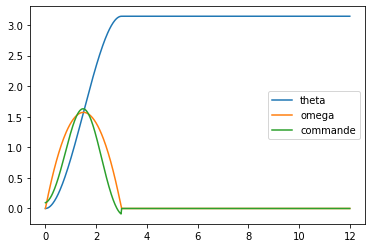

In [6]:
theta_list = [thetar(i) for i in time]
omega_list = [dthetar(i) for i in time]
ur_list = [ur(i) for i in time]

%matplotlib inline
plt.plot(time,theta_list,label="theta")
plt.plot(time,omega_list,label="omega")
plt.plot(time,ur_list,label="commande")
plt.legend()
plt.show()

Nous pouvons définir une fonction d'animation pour voir a quoi cette trajectoire ressemble

<IPython.core.display.Javascript object>


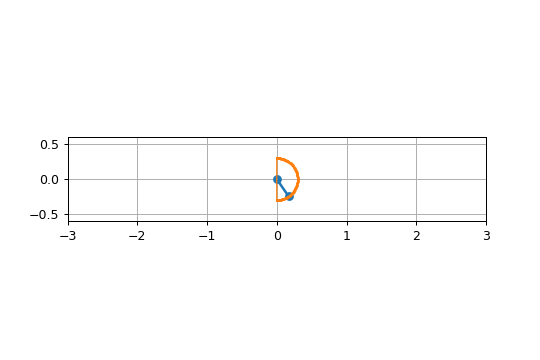

In [7]:
def create_animation (time, theta, x_cart = np.zeros(len(time)) ): 
    # fonction d'animation qui prend en arguments une liste d'angles ET une liste de positions en X (j'anticipe un peu ici)
    fig = plt.figure()
    ax = fig.add_subplot(autoscale_on = False,xlim=(-3,3),ylim =(-L*2, L*2))
    ax.set_aspect('equal')
    ax.grid()

    line, =ax.plot([],[],"o-",linewidth=2)
    trace, =ax.plot([],[],".-",linewidth=1,markersize = 2)
    history_x, history_y = collections.deque(maxlen=len(time)), collections.deque(maxlen=len(time)) #deque collections for fixed    length of past trajectory

    #x, y coordinates to display
    x_bob= np.array(L*np.sin(theta))
    y_bob= np.array(-L*np.cos(theta))


    def animate(i):
        thisx=[x_cart[i],x_cart[i]+ x_bob[i]] # ici,l'x d'une extrémité du trait est celle de la base du pendule (0 par défaut), et l'autre celle du bout du pendule 
        thisy=[0,y_bob[i]]

        if i ==len(time):
            history_x.clear()
            history_y.clear()

        history_x.appendleft(thisx[1])
        history_y.appendleft(thisy[1])

        line.set_data(thisx,thisy)
        trace.set_data(history_x,history_y)

        return line, trace
    return animation.FuncAnimation(fig,animate,frames=len(time),interval=10,blit=True,repeat_delay= 500)

%matplotlib notebook
%matplotlib notebook
create_animation(time,theta_list)

Nous obtenons ainsi la trajactoire et commandes de référence désirées. Notre pendule est maintenant en la position désirée avec une vitesse nulle. En théorie, aucun controle n'est d'orénavant nécessaire puisque celle ci est une position d'équilibre. 

En pratique, la résolution de l'équation du mouvement nous indiquera la vraie dynamique du pendule.

### B) Simulation du pendule en boucle ouverte : u = $u_{ref}$

Définissons tout premièrement une fonction qui crée un système d'équations différentielles du premier ordre. Nous utiliserons alors la fonction odeint de scipy.integrate pour trouver la solution à l'équation différentielle de manière numérique.

Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 196, in process
    func(*args, **kwargs)
  File "C:\Users\romai\anaconda3\lib\site-packages\matplotlib\animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


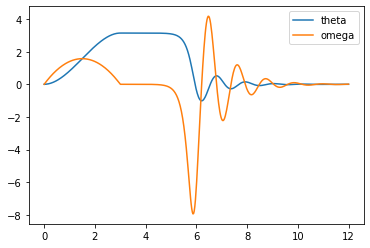

In [8]:
def pend_bo(y, t):
    J = m*(L**2)
    theta, omega = y
    dydt = [omega, (1/J)*(-lambdas*omega - m*g*L*np.sin(theta) + ur(t))]

    return dydt

x_integrated = scipy.integrate.odeint(func=pend_bo,y0=[0,0],t=time)

%matplotlib inline

plt.plot(time,x_integrated[:,0],label="theta")
plt.plot(time,x_integrated[:,1],label="omega")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


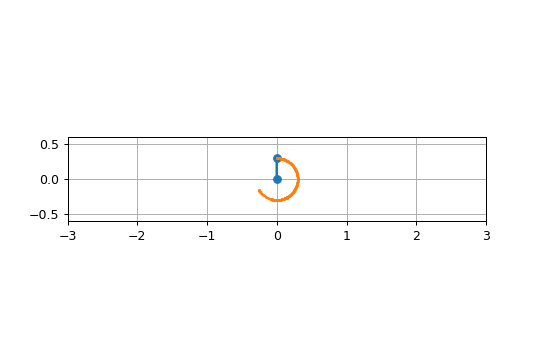

In [11]:
%matplotlib notebook
%matplotlib notebook
create_animation(time,x_integrated[:,0])

On constate que le programme en boucle ouverte ne suffit pas, le systeme rechute vers la position d'équilibre stable $\theta = 0.$

Nous devons alors effectuer une boucle fermée avec retroconntrole en plus de la trajectoire de référence initiale.


### C) Simulation du pendule en boucle fermée : u = $u_{ref} -K(x - x_{ref})$ (stabilisation)

Nous souhaitons stabiliser notre système autour d'un point d'équilibre. Actuellement notre système est sous la forme 
$$\dot x = F(x,u) $$ ou 

$$
\left\{ \begin{array}{ll}   F_{1}(x,u)= \dot\theta & \\  F_{2}(x,u)= \ddot\theta = \frac{1}{ml^2}(-\lambda\dot\theta -mgsin(\theta) + u(t) )  \end{array}
\right.
$$

Afin de pouvoir stabiliser le pendule, nous souhaitons linéariser le système, c'est à dire le mettre sous la forme :
$$\dot X = AX + BU$$ 
$ou \; X = x-x_{eq} \;et\;U = u-u_{eq} $
 
On remarque qu'on obtient une telle linéarisation en développant la fonction F autour de ce point d'équilibre.

Ici $A =\frac{dF}{dx}(x_{eq},u_{eq})$ et $B = \frac{dF}{du}(x_{eq},u_{eq}$). A et B sont donc les matrices Jacobiennes de F donc :


$$A = \left(\begin{array}{cc} 0 && 1 \\ -\frac{g\cos(x_{eq})}{l} && -\frac{\lambda}{ml^2}\end{array}\right) \;\;\;\;\;\;\; 
et \;\;\;\;\;\;\; B= \left(\begin{array}{cc} 0 \\ \frac{1}{ml^2} \end{array}\right) $$  

On va alors cherche la matrice de gain K tq U = -KX pour ovtenir le système final:
$$\dot X = (A - BK)X$$

avec la matrice A-BK qui possède des valeurs propres à parties réelles négatives, pour s'assurer la convergence du système.

Cette matrice de gain peut être obtenue par deux méthode, une dite de "placement des poles" ou il existe directement une formule pour celle ci, et il suffit de choisir les valeurs propres de la matrice (A-BK) (négatifs de préférence). C'est cette premiere méthode que nous utiliserons ici.
La seconde méthode de LQR repose sur la minimisation d'une fonction de cout, ou l'on trouve le u (et donc le K) optimal. Cette méthode est accessible avec la fonction control.lqr de la librairie control pour python. Puisqu'il faudrait importer une librairie qui n'est pas installée sur python par défaut, nous n'utiliserons pas cette méthode.

Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 196, in process
    func(*args, **kwargs)
  File "C:\Users\romai\anaconda3\lib\site-packages\matplotlib\animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


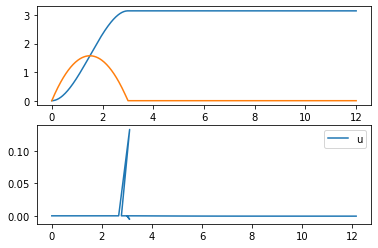

In [12]:
%matplotlib inline

A =np.array([ [0,1],[g/L,-lambdas/(m*L**2)] ])
B = np.array([[0],[1/(m*L**2)]])

comm =np.concatenate([B,A@B],axis=1)  
# matrice de commandabilité = (B AB) ou AB,B vecteurs colonnes
# avec np.linalg.eigvals(comm) on voit que sont rang = 2 donc système commandable selon le critère de commandabilité de Kalmann
#avec la formule d'Ackermann, nous pouvons commander ce systeme a sont pt d'équilibre 

comminv= np.linalg.inv(comm)

K = [0,1]@comminv@(A+np.identity(2))@(A+np.identity(2))
#calcul de la matrice de gain selon la formule d'Ackermann, on place les poles avec le polynome de matrices de A. 

#on redéfinit alors u = ur + K(x-xeq)

commande = {}
def pend_bf(y, t):
    J = m*(L**2)
    theta, omega = y
    dydt = [omega, (1/J)*(-lambdas*omega - m*g*L*np.sin(theta) + ur(t) - K@([theta-thetar(t),omega-dthetar(t)]))]
    commande[t] = K@([theta-thetar(t),omega-dthetar(t)])
    return dydt
    
x_integrated_K = scipy.integrate.odeint(func=pend_bf,y0=[0,0],t=time)

figure, axis = plt.subplots(2)

axis[0].plot(time,x_integrated_K[:,0],label="theta")
axis[0].plot(time,x_integrated_K[:,1],label="omega")
axis[1].plot(list(commande.keys()),list(commande.values()),label="u")
plt.legend()
plt.show()


Nous avons ici un controle efficace du pendule en position d'équilibre. Bien que la commande paraisse nulle, en zoomant un peu, on voit qu'elle est bien active et que c'est grace à son action continue que le pendule reste ne position d'équilibre instable.

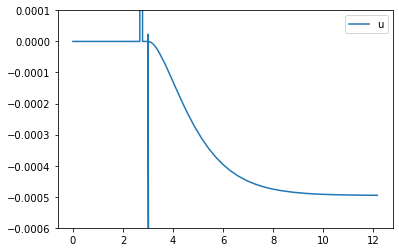

In [13]:

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(commande.keys()),list(commande.values()),label="u")
plt.ylim(-0.0006,0.0001)
plt.legend()
plt.show()
plt.close()

En animation cela nous donne : 

<IPython.core.display.Javascript object>


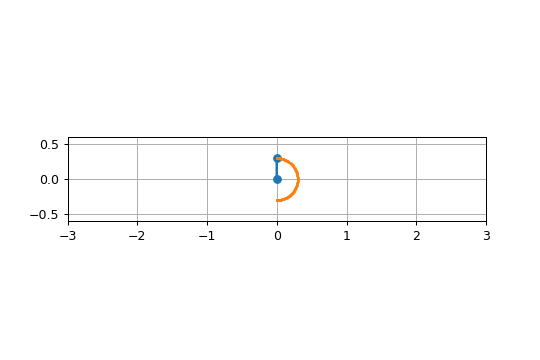

In [14]:
%matplotlib notebook
%matplotlib notebook

create_animation(time,x_integrated_K[:,0])

Cependant, ici la controle est appliquée directement comme un couple sur le pendule. Ceci nécéssiterait de monter le pendule directement sur un moteur. Un problme intéréssant serait de controler ce pendule simple, qui serait attaché a sa base à un chariot effectuant une translation selon 1 axe.

Nous allons alors nous interesser à ce problème dans la prochaine partie.

## 2) Pendule sur un chariot

Nous désirons d'orénavant un système de pendule + chariot. Le pendule simple est alors attaché sur le chariot, qui est motorisé et donc d'effectuer un mouvement de translation selon l'axe des x. Nous ne pouvons pas appliquer de moment directement sur le pendule, et essayeront donc d'ammener le pendule à une position d'équilibre instable par l'usage du chariot. 

Nous avons maintenant un nouveau vecteur de système : 

$$X= \left(\begin{array}{cc} \theta \\ \dot\theta \\ x \\ \dot x \end{array}\right) \;\;\;\;\;\;\; \dot X= \left(\begin{array}{cc} \dot\theta \\ \ddot\theta \\ \dot x \\ \ddot x \end{array}\right)$$ 

Nos deux équations de système sont : 
	$$ L\ddot\theta = -g sin(\theta) + \ddot x cos(\theta)$$
	$$(m + M)\ddot x = - m \ddot \theta L cos(\theta) + m L \dot\theta^2 sin(\theta) $$

Afin de résoudre notre problème nous devons mettre les équations sous la forme : $$\dot X = F(X,U)$$

Nous obtenons alors le système d'équations :
$$\ddot \theta= \frac{L\dot\theta^2 sin(\theta) cos(\theta) -g b sin(\theta)}{L(b + cos(\theta)^2 )}$$

$$\ddot x= \frac{L\dot\theta^2sin(\theta) - gcos(\theta)sin\theta}{b + cos(\theta)^2}$$

avec $b= \frac{m+M}{m}$

On peut vérifier que les équations sont correctes en animant le pendule à une position qui n'est pas d'équilibre, et voir si le comportement du système est "physique". Ceci va aussi nous permettre d'adapter le code d'animation afin de rendre la base du pendule mobile.

Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 196, in process
    func(*args, **kwargs)
  File "C:\Users\romai\anaconda3\lib\site-packages\matplotlib\animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


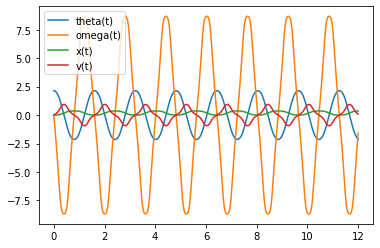

In [15]:
%matplotlib inline
def pend_bf_cart(y, t):   #fonction aux dérivées du nouveau système
    J = m*(L**2)
    b = (m+M)/m
    theta, omega, x, v = y
    dydt = np.zeros(4)
    dydt[0] = omega
    dydt[1] = (L*np.sin(theta)*np.cos(theta)*(omega)**(2) - g*b*np.sin(theta))/(L*(b + np.cos(theta)**2))
    dydt[2] = v
    dydt[3] = ( L*np.sin(theta)*omega**2 - g*np.cos(theta)*np.sin(theta))/(b + np.cos(theta)**2)

    return dydt

sol_cart_pendulum = scipy.integrate.odeint(pend_bf_cart, y0=[np.pi-1,0,0,0], t=time)    #on résoud le système d'équations 


plt.plot(time, sol_cart_pendulum[:,0], label='theta(t)')
plt.plot(time, sol_cart_pendulum[:,1], label='omega(t)')
plt.plot(time, sol_cart_pendulum[:,2], label='x(t)')
plt.plot(time, sol_cart_pendulum[:,3], label='v(t)')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


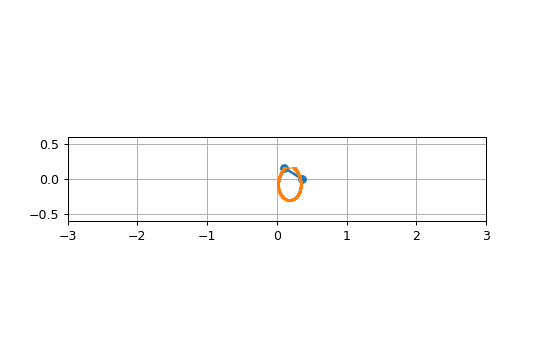

In [16]:
%matplotlib notebook
%matplotlib notebook
create_animation(time,sol_cart_pendulum[:,0],sol_cart_pendulum[:,2])

### A) Stabilisation autour d'un point d'équilibre

Nous désirons ici aussi linéariser le système autour de la position d'équilibre instable $ \theta = \pi$

Ici la commande passe par le biais d'une force appliquée sur le chariot dans la direction des x. Si on effectue le PFD sur le chariot et qu'on néglige les éventuels frottements, on a que : 

$$ \ddot x = u $$
et avec la première équation du mouvement on en déduit : 
$$\ddot\theta = \frac{u cos(\theta) -g sin(\theta)}{L}$$

Notre système devient alors grandement simplifié et nous pouvons le linéariser proche d'une position d'équilibre $\theta = \pi$ pour que $sin \theta \approx \theta$ et $ cos \theta \approx 1$. Nous obtenons alors : 

$$\ddot\theta = \frac{u-g \theta}{L}$$

$$ \dot X = \left(\begin{array}{cc} 0 && 1 && 0 && 0 \\ -g/L && 0 && 0 && 0 \\ 0 && 0 && 0 && 1 \\ 0 && 0 && 0 && 0\end{array}\right)X + \left(\begin{array}{cc} 0 \\ 1/L \\ 0 \\ 1\end{array}\right)u $$ 

ie 
$$\dot X = AX + Bu$$

La matrice de commandabilité est 
 [[   0.            3.33333333    0.         -109.        ]
 [   3.33333333    0.         -109.            0.        ]
 [   0.            1.            0.            0.        ]
 [   1.            0.            0.            0.        ]] 

Ses valeurs propres sont 

 [-1.66666667+10.30641656j -1.66666667-10.30641656j
  1.66666667+10.30641656j  1.66666667-10.30641656j]

Les matrices de gain obtenues par placement des poles et LQR sont respectivement

 [-0.04587156  0.00917431  0.1529052  -0.03058104] 
 [50.  15.   3.1  4.8]


Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 196, in process
    func(*args, **kwargs)
  File "C:\Users\romai\anaconda3\lib\site-packages\matplotlib\animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


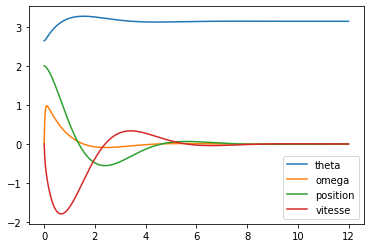

In [17]:
%matplotlib inline


A =np.array([ [0,1,0,0],[-g/L,0,0,0],[0,0,0,1],[0,0,0,0] ])
B = np.array([[0],[1/L],[0],[1]])

# matrice de commandabilité = (B AB) ou AB,B vecteurs colonnes
# avec np.linalg.eigvals(comm) on voit que sont rang = 4 donc système commandable

comm =np.concatenate([B,A@B,A@A@B,A@A@A@B],axis=1)  

print("La matrice de commandabilité est \n",comm, "\n\nSes valeurs propres sont \n\n",np.linalg.eigvals(comm))


#avec la formule d'Ackermann, nous pouvons commander ce systeme a sont pt d'équilibre 

comminv= np.linalg.inv(comm)

K = [0,0,0,1]@comminv@(-3*A**3 + A**2 + A +5*np.identity(4))  # matrice de commandabilité par placement des poles         

Kp = np.array([50,15,3.1,4.8])     # matrice obtenue par méthode LQR calculée sur matlab pour notre système.

print("\nLes matrices de gain obtenues par placement des poles et LQR sont respectivement\n\n",K,"\n",Kp)

#Je ne sais pas trop pourquoi, mais la matrice de gain obtenue par placement des poles ne fonctionne pas du tout,
# j'ai donc décidé d'utiliser la méthode lqr hors du programme et ai mit les valeurs ici, pour que le controlleur fonctionne.
#

#on redéfinit alors u =  K(x-xeq)

commande = {}
def pendcart_bf(y, t):
    theta, omega, x, v = y
    U = K@[theta-np.pi,omega,x,v]   # commande qui ne marche pas
    Up = Kp@[theta-np.pi,omega,x,v] # commande fonctionnelle
    
    dydt = [omega,(Up*np.cos(theta) - g*np.sin(theta))/L,v, Up]
    
    return dydt
    
x_cart_controlled = scipy.integrate.odeint(func=pendcart_bf,y0=[np.pi-0.5,0,2,0],t=time)

#figure, axis = plt.subplots(2)

plt.plot(time,x_cart_controlled[:,0],label="theta")
plt.plot(time,x_cart_controlled[:,1],label="omega")
plt.plot(time,x_cart_controlled[:,2],label="position")
plt.plot(time,x_cart_controlled[:,3],label="vitesse")
#axis[1].plot(list(commande.keys()),list(commande.values()),label="u")
#plt.ylim(-4,4)
plt.legend()

plt.show()


<IPython.core.display.Javascript object>


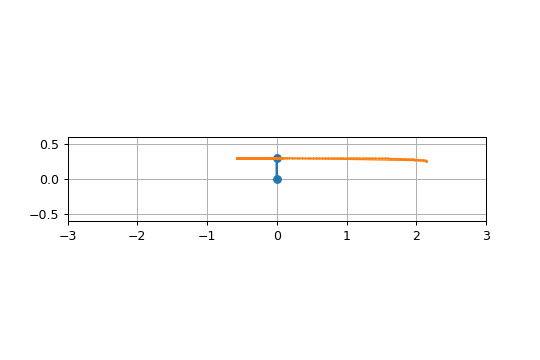

In [18]:
%matplotlib notebook
%matplotlib notebook

create_animation(time,x_cart_controlled[:,0],x_cart_controlled[:,2])

### B) "Swing up" du pendule 

Maintenant il nous faut créer une trajectoire de référence capable d'ammener notre système de l'état 
$$X= \left(\begin{array}{cc} 0 \\ 0 \\ x \\ 0 \end{array}\right) \;\;\;à\;\;\;\;  \left(\begin{array}{cc} \pi \\ 0 \\ 0 \\ 0 \end{array}\right)$$ 

Nous allons créer une commande basée sur la minimisation de la valeur $E-E_{eq}$. 
Ici l'énergie mécaninque du pendule est : 

$E = \frac{1}{2} m L^2 \dot \theta^2 + mgL(1 - cos(\theta))$

et l'énergie finale désirée est celle lorsque le pendule est immobile et $\theta = \pi$ donc :

$E_{eq} = 2mgL$

La commande qui sera appliquée en effectif sera $ u = k(E - E_{eq}) \dot \theta cos(\theta) $ d'après la littérature.

Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 196, in process
    func(*args, **kwargs)
  File "C:\Users\romai\anaconda3\lib\site-packages\matplotlib\animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


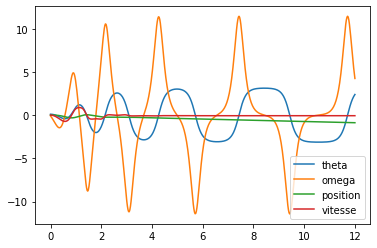

In [19]:
%matplotlib inline 

def energy(theta, dtheta):
    return m * L*L*dtheta*dtheta/2 + m * g * L * (1 - np.cos(theta))  

k = 0.5 # ce gain est utilisé pour la commande appliquée au pendule. Plus elle est grande et plus l'effort du moteur sera important

def swing_up(y, t):
    theta, omega, x, v = y
    
    E = energy(theta,omega)
    U = -k* (E - 2*m*g*L) * omega * np.cos(theta)   # commande par minimisation d'énergie. Voir sources pour origine de la formule

    dydt = [omega,(U*np.cos(theta) - g*np.sin(theta))/L,v, U]
    return dydt

x_swingup = scipy.integrate.odeint(func=swing_up,y0=[0.1,-0.1,0,0],t=time)



plt.plot(time,x_swingup[:,0],label="theta")
plt.plot(time,x_swingup[:,1],label="omega")
plt.plot(time,x_swingup[:,2],label="position")
plt.plot(time,x_swingup[:,3],label="vitesse")
plt.legend()

plt.show()



<IPython.core.display.Javascript object>


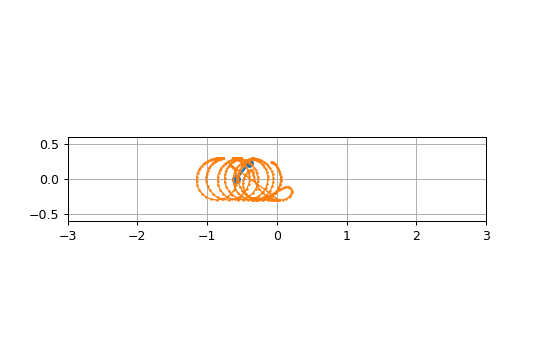

In [20]:
%matplotlib notebook
%matplotlib notebook
create_animation(time,x_swingup[:,0],x_swingup[:,2])


### D) Trajectoire + controle du pendule

Nous allons maintenant combiner les deux commandes afin d'obtenir une trajectoire pour ammener a la position d'équilibre instable et ensuite de l'y maintenir. 

Pour faire cela, nous appliquons la commande de minimisation d'énergie au pendule, jusqu'a ce que $\theta$ soit assez proche de pi pour passer à l'autre commande de stabilisation.

Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 196, in process
    func(*args, **kwargs)
  File "C:\Users\romai\anaconda3\lib\site-packages\matplotlib\animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


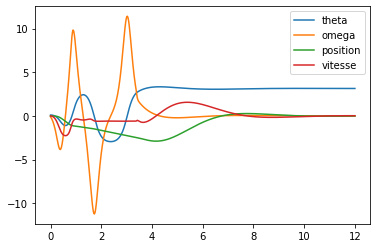

In [21]:
%matplotlib inline
def controllable(th):
    return np.pi - th<= 0.5

def swing_up_controlled(y, t):
    theta, omega, x, v = y
    if controllable(theta) :
        U = 50*(theta - np.pi) + 15*omega + 3.1*x + 4.8*v    
    else :
        E = energy(theta,omega)
        U = -1.8*k* (E - 2*m*g*L) * omega * np.cos(theta)
        
    dydt = [omega,(U*np.cos(theta) - g*np.sin(theta))/L,v, U]
    return dydt


x_swingup_controlled = scipy.integrate.odeint(func=swing_up_controlled,y0=[0.1,-0.1,0,0],t=time)


plt.plot(time,x_swingup_controlled[:,0],label="theta")
plt.plot(time,x_swingup_controlled[:,1],label="omega")
plt.plot(time,x_swingup_controlled[:,2],label="position")
plt.plot(time,x_swingup_controlled[:,3],label="vitesse")
plt.legend()

plt.show()

<IPython.core.display.Javascript object>


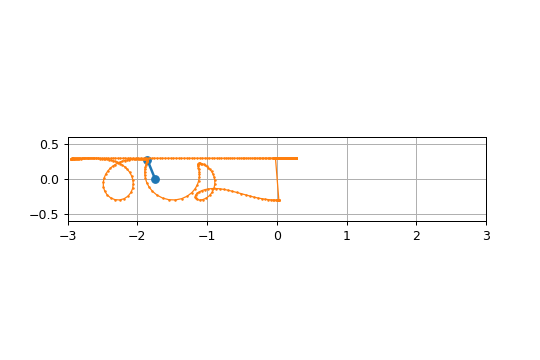

In [22]:
%matplotlib notebook
%matplotlib notebook
create_animation(time,x_swingup_controlled[:,0],x_swingup_controlled[:,2])

## Sandbox 

Cette partie est la pour s'amuser, choisissez les coordonnées généralisées de départ $(x,\theta)$ et celles d'arrivée, choisissez le gain de la commande et regarder si le pendule arrive a se stabiliser ! 

In [23]:
def simulateur(xi,thi,xf,k=0.5):

    def swing_up_controlled(y, t):
        theta, omega, x, v = y
        if controllable(theta) :
            U = 50*(theta - np.pi) + 15*omega + 3.1*(x-xf) + 4.8*v    
        else :
            E = energy(theta,omega)
            U = -k* (E - 2*m*g*L) * omega * np.cos(theta)
        
        dydt = [omega,(U*np.cos(theta) - g*np.sin(theta))/L,v, U]
        return dydt

    xlist = scipy.integrate.odeint(func=swing_up_controlled,y0=[thi,-0.1,xi,0],t=time)


    plt.plot(time,xlist[:,0],label="theta")
    plt.plot(time,xlist[:,1],label="omega")
    plt.plot(time,xlist[:,2],label="position")
    plt.plot(time,xlist[:,3],label="vitesse")
    plt.legend()

    plt.show()
    return plt.plot, create_animation(time,xlist[:,0],xlist[:,2])

Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 196, in process
    func(*args, **kwargs)
  File "C:\Users\romai\anaconda3\lib\site-packages\matplotlib\animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


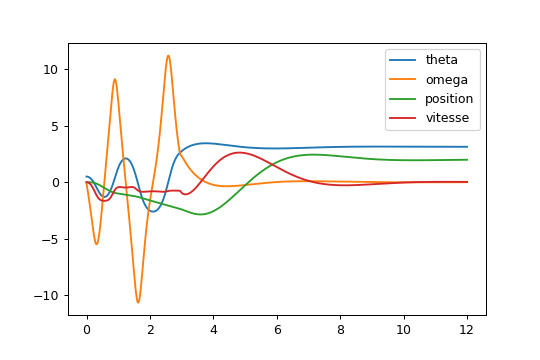

<IPython.core.display.Javascript object>


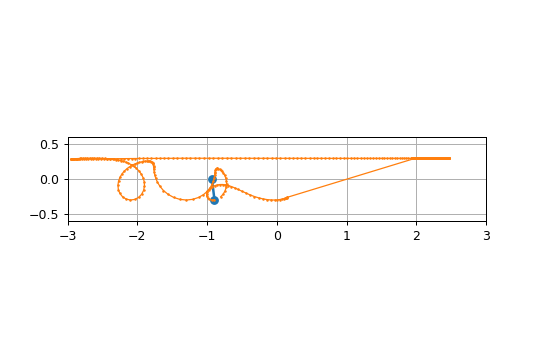

(<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>,
 <matplotlib.animation.FuncAnimation at 0x16099b89580>)

In [24]:
%matplotlib notebook
%matplotlib notebook

#simulateur(xdépart, théta départ, xfinal)
simulateur(0,0.5,2)

# Sources 

###### La formule de commande de swing-up par minimisation d'énergie provient de l'article suivant : 

Åström, K.J., et K. Furuta. «Swinging up a Pendulum by Energy Control ». Automatica 36, no 2 (février 2000): 287‑95. 
https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.127.6834&rep=rep1&type=pdf

###### Pour une explication des 2 méthodes de stabilisation par placement de poles (formule d'Ackermann) ou par LQR :

Banerjee, Ramashis, et Arnab Pal. « Stabilization Of Inverted Pendulum On Cart Based On Pole Placement and LQR ». In 2018 International Conference on Circuits and Systems in Digital Enterprise Technology (ICCSDET), 1‑5. Kottayam, India: IEEE, 2018. https://www.researchgate.net/publication/335571326_Stabilization_Of_Inverted_Pendulum_On_Cart_Based_On_Pole_Placement_and_LQR

###### Pages wikipedia utiles :

Formule d'Akermann

https://en.wikipedia.org/wiki/Ackermann%27s_formula

Régulateur Quadratique Linéaire (LQR)

https://en.wikipedia.org/wiki/Linear%E2%80%93quadratic_regulator